In [35]:
import numpy as np   
import pandas as pd  
import os
import gc
import seaborn as sns  # for plotting graphs
import matplotlib.pyplot as plt # for plotting graphs aswell
import glob
from datetime import datetime
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import log_loss,roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import coo_matrix, hstack
import lightgbm
from sklearn.model_selection import KFold

from lightgbm import LGBMClassifier
%matplotlib inline



In [3]:
# to display maximum rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


In [4]:
# function to set all numerical data to int16 or float16, to save on memory use
def dtype_conver(Dataframe):
    for col in Dataframe:
        if Dataframe[col].dtype == 'float32' or 'float64':
            Dataframe[col] = Dataframe[col].astype(np.float16)
        if Dataframe[col].dtype == 'int8' or 'int32' or 'float64':
            Dataframe[col] = Dataframe[col].astype(np.int16)

In [5]:
# Read in filepath  
DATA_PATH = r'C:/Users/t891199/Desktop/Big_Data_Diploma/CEBD_1260_Machine_learning/Data Files/Class_3/'
file_name = os.path.join(DATA_PATH,'train.csv')


In [6]:
# pandas reads in csv file using filepath
old_train_df = pd.read_csv(file_name)
print(old_train_df.shape)
#original_quote_date is time-series

(260753, 299)


In [7]:
#Feature Engineering
old_train_df['Original_Quote_Date'] = pd.to_datetime(old_train_df['Original_Quote_Date'])
old_train_df['year'] = old_train_df['Original_Quote_Date'].dt.year
old_train_df['month'] = old_train_df['Original_Quote_Date'].dt.month
old_train_df['day'] = old_train_df['Original_Quote_Date'].dt.day

In [8]:
train_df = old_train_df.drop(["Original_Quote_Date"], axis = 1)
# lets see how many NaN or Null values are in each column
nan_info = pd.DataFrame(train_df.isnull().sum()).reset_index()
nan_info.columns = ['col','nan_cnt']


In [9]:
#sort them in descending order and print 1st 10
nan_info.sort_values(by = 'nan_cnt',ascending=False,inplace=True)
nan_info.head(10)

,col,nan_cnt
160,PropertyField29,200685
124,PersonalField84,124208
169,PropertyField38,1220
167,PropertyField36,113
48,PersonalField7,113
129,PropertyField3,81
163,PropertyField32,70
165,PropertyField34,70
130,PropertyField4,63
198,GeographicField14A,0


In [10]:
# extract column names with NaNs and Nulls
# numerical cols with missing values
num_cols_with_missing = ['PersonalField84','PropertyField29']



In [11]:
#boolean type cols with missing values
bool_cols_with_missing = ['PropertyField3','PropertyField4','PersonalField7','PropertyField32',
                          'PropertyField34','PropertyField36','PropertyField38']


In [12]:
# fill in null and NaN values with 'U' in boolean type cols ( 'Y','N')
for cols in bool_cols_with_missing:
    train_df[cols].fillna('U',inplace=True)



In [13]:
# fill in null and NaN values with -1 in numerical missing values
for cols in num_cols_with_missing:
    train_df[cols].fillna(-1, inplace=True)


In [14]:
# define target
y = old_train_df["QuoteConversion_Flag"].values

In [15]:
# drop target column from data
X = train_df.drop(["QuoteConversion_Flag"], axis = 1)


In [ ]:
#drop geographic field 10A since it shows all the same value, could be identifying country
# property Field6 also all zeros we should drop also
#log of salesfield8 then hstack to bring back into sparse matrix

In [16]:
#QuoteNumber setting as index
X = X.set_index("QuoteNumber")



In [17]:
# select all columns that are categorical i.e with unique categories less than 40 in our case
X_for_ohe = [cols for cols in X.columns if X[cols].nunique() < 40 or X[cols].dtype in['object']]
X_not_ohe = [cols for cols in X.columns if X[cols].nunique() > 40 and X[cols].dtype not in['object']]


In [18]:
#numerical column that we will not encode
X[X_not_ohe].head()


,SalesField8
QuoteNumber,
1,48649
2,26778
4,8751
6,43854
8,12505


In [19]:
#to keep track of our columns, how many are remaining after we removed 4 so far?
len(X_for_ohe)

298

In [20]:
nan_info = pd.DataFrame(X[X_for_ohe].isnull().sum()).reset_index()
nan_info.columns = ['col','nan_cnt']

In [21]:
#sort them in descending order and print 1st 10
nan_info.sort_values(by = 'nan_cnt',ascending=False,inplace=True)
nan_info.head(10)

,col,nan_cnt
0,Field6,0
204,GeographicField18B,0
202,GeographicField17B,0
201,GeographicField17A,0
200,GeographicField16B,0
199,GeographicField16A,0
198,GeographicField15B,0
197,GeographicField15A,0
196,GeographicField14B,0
195,GeographicField14A,0


In [22]:
# import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(categories = 'auto',sparse=True)


In [23]:
# apply OneHotEncoder on categorical feature columns
X_ohe = ohe.fit_transform(X[X_for_ohe])


In [24]:
# we are pretty much done for now here, apparently we can set 'sparse = True' in OneHotEncoder and we get a 
#csr_matrix. I left it as false so that you can see the sparse matrix
X_ohe


<260753x5058 sparse matrix of type '<class 'numpy.float64'>'
	with 77704394 stored elements in Compressed Sparse Row format>

In [25]:
X_ohe.shape

(260753, 5058)

In [26]:
X['SalesField8'].shape

(260753,)

In [ ]:
#Need to add back in Salesfield8 USe Hstack, before that use log of Salesfield8

In [33]:
#Parameters for lightGBM classification
model_lgb = LGBMClassifier(
        n_jobs=4,
        n_estimators=100000,
        boost_from_average='false',
        learning_rate=0.02,
        num_leaves=64,
        num_threads=4,
        max_depth=7,
        tree_learner = "serial",
        feature_fraction = 0.7,
        bagging_freq = 5,
        bagging_fraction = 0.5,
#         min_data_in_leaf = 75,
#         min_sum_hessian_in_leaf = 50.0,
        silent=-1,
        verbose=-1,
        device='cpu',
        )

In [28]:
kf = KFold(n_splits=5, random_state=10, shuffle=True)

Fold :0
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.956349	training's binary_logloss: 0.23659	valid_1's auc: 0.954934	valid_1's binary_logloss: 0.236136
[200]	training's auc: 0.960346	training's binary_logloss: 0.190181	valid_1's auc: 0.958273	valid_1's binary_logloss: 0.190904
[300]	training's auc: 0.963806	training's binary_logloss: 0.177824	valid_1's auc: 0.960434	valid_1's binary_logloss: 0.180933
[400]	training's auc: 0.967169	training's binary_logloss: 0.170128	valid_1's auc: 0.961874	valid_1's binary_logloss: 0.176688
[500]	training's auc: 0.970022	training's binary_logloss: 0.163974	valid_1's auc: 0.962687	valid_1's binary_logloss: 0.17427
[600]	training's auc: 0.972354	training's binary_logloss: 0.159235	valid_1's auc: 0.96317	valid_1's binary_logloss: 0.173036
[700]	training's auc: 0.974473	training's binary_logloss: 0.155004	valid_1's auc: 0.963435	valid_1's binary_logloss: 0.172301
[800]	training's auc: 0.976326	training's binary_log

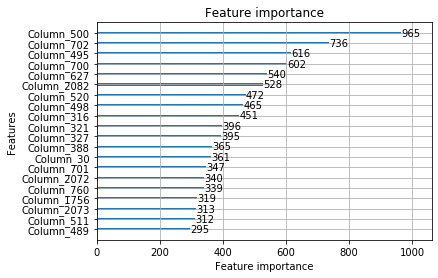

Fold :1
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.9566	training's binary_logloss: 0.237192	valid_1's auc: 0.954724	valid_1's binary_logloss: 0.240395
[200]	training's auc: 0.960164	training's binary_logloss: 0.189817	valid_1's auc: 0.957797	valid_1's binary_logloss: 0.194619
[300]	training's auc: 0.963734	training's binary_logloss: 0.177689	valid_1's auc: 0.960181	valid_1's binary_logloss: 0.184659
[400]	training's auc: 0.967156	training's binary_logloss: 0.169612	valid_1's auc: 0.961711	valid_1's binary_logloss: 0.179802
[500]	training's auc: 0.969896	training's binary_logloss: 0.164088	valid_1's auc: 0.96238	valid_1's binary_logloss: 0.17787
[600]	training's auc: 0.972318	training's binary_logloss: 0.158995	valid_1's auc: 0.962967	valid_1's binary_logloss: 0.176133


In [ ]:
scores = []
for i,(tr_idx, val_idx) in enumerate(kf.split(X_ohe,y)):
    print('Fold :{}'.format(i))
    tr_X = X_ohe[tr_idx]  # training for this loop
    tr_y = y[tr_idx] #
    val_X = X_ohe[val_idx]# validation data for this loop
    val_y = y[val_idx]
    # here build your models
    model = model_lgb
    model.fit(tr_X, tr_y, eval_set=[(tr_X, tr_y), (val_X, val_y)], eval_metric = 'auc', verbose=100, early_stopping_rounds= 50)
    #picking best model?
    pred_val_y = model.predict_proba(val_X,num_iteration=model.best_iteration_)[:,1]
    #y_pred = model.predict(val_X)
    #measuring model vs validation
    score = roc_auc_score(val_y,pred_val_y)
    scores.append(score)
    print('current performance by auc:{}'.format(score))
    lightgbm.plot_importance(model, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance', xlabel='Feature importance', ylabel='Features', importance_type='split', max_num_features=20, ignore_zero=True, figsize=None, grid=True, precision=3)
    plt.show()
    #could use plt.savefig to save them